# Data Exploration and Feature Grouping

In this notebook we do some quick cleaning of the dataset and perform LDA with features grouped according to correlation.  

In [1]:
# import libraries needed

import pandas as pd
import numpy as np
from pennylane import numpy as np
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

import pennylane as qml
from pennylane_qiskit import IBMQDevice
from pennylane_qiskit import BasicAerDevice
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding
from pennylane.optimize import AdamOptimizer
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# visualization

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
start = time.time()

## Quick Clean-up and Feature Grouping

In [126]:
# Read out CSV and sets/samples creation

df = pd.read_csv('fraud_detection_bank_dataset.csv', sep=',')
df = df.astype(float)
df = df.drop(['Unnamed: 0'], axis = 1)
df.describe()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
count,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.0,20468.0,...,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000
mean,3.226256,294.793043,0.420021,2.329343,0.083594,0.939857,2.386066,3.226256,0.0,0.0,...,0.004935,0.358120,0.002443,0.308384,0.190737,0.000049,0.049345,0.024282,43.486125,0.265683
std,20.564308,717.541984,7.367275,10.068512,0.840537,4.222896,3.018140,20.564308,0.0,0.0,...,0.073478,0.479459,0.049366,0.461837,0.392892,0.006990,0.216593,0.305079,59.217560,0.441707
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
50%,0.000000,97.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000
75%,2.000000,283.000000,0.000000,2.000000,0.000000,1.000000,6.000000,2.000000,0.0,0.0,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,61.250000,1.000000
max,2301.000000,37808.000000,904.000000,772.000000,54.000000,230.000000,11.000000,2301.000000,0.0,0.0,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17.000000,747.000000,1.000000


Some columns seem to be all zeros. Let's drop them as they provide no differentiation between observations.

In [127]:
df_clean = df.loc[:, df.any()]
df_clean.describe()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_13,col_14,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
count,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,...,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000
mean,3.226256,294.793043,0.420021,2.329343,0.083594,0.939857,2.386066,3.226256,0.038646,0.363152,...,0.004935,0.358120,0.002443,0.308384,0.190737,0.000049,0.049345,0.024282,43.486125,0.265683
std,20.564308,717.541984,7.367275,10.068512,0.840537,4.222896,3.018140,20.564308,0.192754,0.480920,...,0.073478,0.479459,0.049366,0.461837,0.392892,0.006990,0.216593,0.305079,59.217560,0.441707
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
50%,0.000000,97.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000
75%,2.000000,283.000000,0.000000,2.000000,0.000000,1.000000,6.000000,2.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,61.250000,1.000000
max,2301.000000,37808.000000,904.000000,772.000000,54.000000,230.000000,11.000000,2301.000000,1.000000,1.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17.000000,747.000000,1.000000


In [128]:
# save the cleaned data

df_clean.to_csv("dataset_nonzero.csv")

We want to split the features into groups that are similar within but distinct between groups. Let's take a look at the correlation matrix.

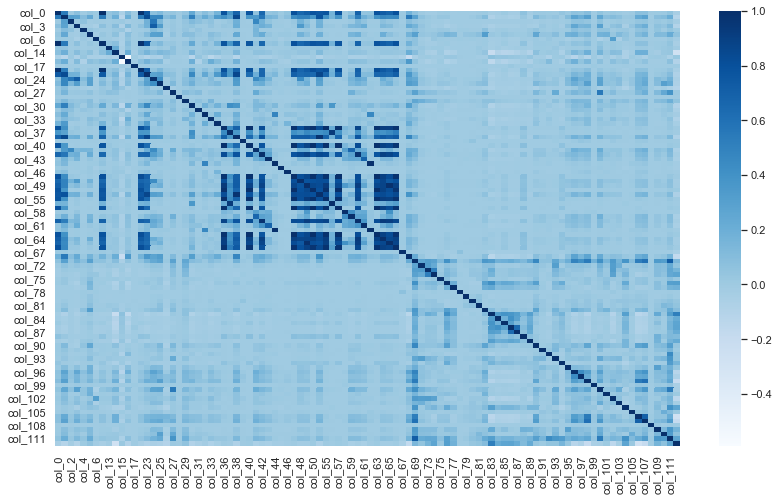

In [129]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df_clean.corr()
heatmap = sns.heatmap(corr, annot=False, cmap="Blues", fmt='.1g')

The correlaton relation falls into two relatively clear patches. Since we are aiming to reduce the features into 2 latent features, the correlation matrix provides pretty good guidance on how to split. Let's take a closer look in the region where the two groups seem to be split.

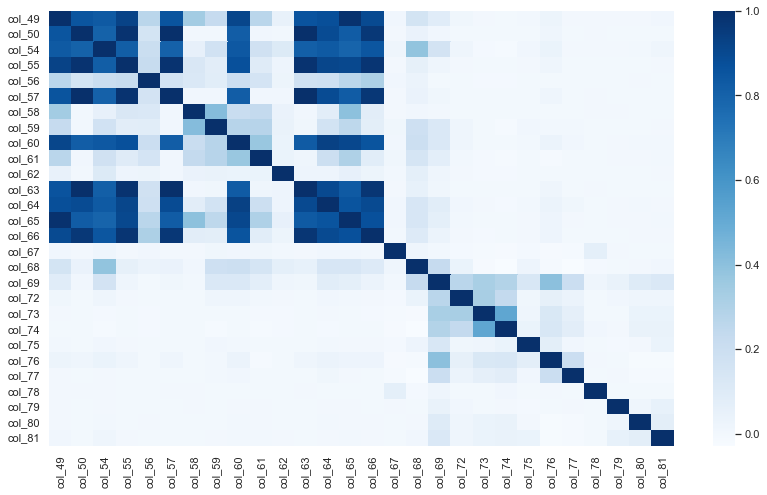

In [130]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df_clean.loc[:,'col_49':'col_81'].corr()
heatmap = sns.heatmap(corr, annot=False, cmap="Blues", fmt='.1g')

We'll group features up to `col_69` into one group and the rest into the other.

In [93]:
df_sample = df_clean.sample(2000)
train,test = train_test_split(df_sample, test_size=0.30, random_state=10)
train_set = train
test_set = test
np.random.seed(42)

In [94]:
# Separation of labels

x_train = train_set
y_train = train_set[['targets']]

x_test = test_set
y_test = test_set[['targets']]

In [131]:
# grouping features
 
features_a = x_train.loc[:,:'col_69']
features_b = x_train.loc[:,'col_69':]

features_a_test = x_test.loc[:,:'col_67']
features_b_test = x_test.loc[:,'col_67':]

## LDA Features

In [133]:
# transform the features

lda = LDA(n_components=1)
features_lda_1 = lda.fit_transform(features_a, y_train.values.ravel())
features_lda_2 = lda.fit_transform(features_b, y_train.values.ravel())

features_lda_1_test = lda.fit_transform(features_a_test, y_test.values.ravel())
features_lda_2_test = lda.fit_transform(features_b_test, y_test.values.ravel())

In [135]:
features_lda_1 = pd.DataFrame(features_lda_1)
features_lda_2 = pd.DataFrame(features_lda_2)

features_lda_1_test = pd.DataFrame(features_lda_1_test)
features_lda_2_test = pd.DataFrame(features_lda_2_test)

In [136]:
features_lda_1.head()

,0
0,0.133929
1,0.529977
2,-0.922923
3,0.487324
4,0.368786


In [137]:
# combine the 2 features

x_train_lda = features_lda_1.join(features_lda_2, lsuffix="_left", rsuffix="_right")
x_test_lda = features_lda_1_test.join(features_lda_2_test, lsuffix="_left", rsuffix="_right")

In [138]:
x_train_lda

,0_left,0_right
0,0.133929,-1.091509
1,0.529977,-0.960667
2,-0.922923,-0.639466
3,0.487324,0.204965
4,0.368786,-0.639466
...,...,...
1395,1.091340,0.604241
1396,-1.423830,-0.052359
1397,-0.065439,-0.052359
1398,-1.012592,-0.591393


In [139]:
x_test_lda

,0_left,0_right
0,0.262410,-0.844093
1,0.016687,-0.403047
2,-0.978751,-1.711895
3,-0.111510,-0.000622
4,0.286865,-0.819957
...,...,...
595,0.675788,3.803108
596,-0.522451,-0.281238
597,-2.422944,0.172625
598,0.764962,-0.097968


In [140]:
# Normalize

std_scale = StandardScaler().fit(x_train_lda)
data = std_scale.transform(x_train_lda)

std_scale = StandardScaler().fit(x_test_lda)
x_test_lda_n = std_scale.transform(x_test_lda)

In [141]:
x_test_lda_n

array([[ 0.2270424 , -0.60888212],
       [ 0.01443808, -0.29073569],
       [-0.84683642, -1.23486658],
       ...,
       [-2.09638321,  0.12452206],
       [ 0.66186192, -0.07066894],
       [ 0.75580324,  1.90386338]])

In [142]:
n_dim = 2

In [143]:
# Review the balance of the target variable in train

y_train.value_counts(normalize=True)*100

targets
0.0        73.857143
1.0        26.142857
dtype: float64

In [144]:
# Review the balance of the target variable in test

y_test.value_counts(normalize=True)*100

targets
0.0        72.5
1.0        27.5
dtype: float64

## QML

We then perform quantum machine learning using the two LDA features.

In [145]:
# Angle Encoding

num_qubits = n_dim

dev = qml.device('default.qubit', wires = num_qubits, shots=1024)
#dev = qml.device('default.qubit.tf', wires = num_qubits, shots=1024)
#dev = qml.device('qiskit.ibmq', wires = num_qubits, backend='ibmq_manila', ibmqx_token="6cc75c58fc80fea56cb8dd391f8fbcfdb676a3dc7005493728bc9da7ea753e31a2110a01e3a0cc83f1a98f5ca79e32956fc66c11b5eea4cae163b3fa996be356", shots=256)
#dev = qml.device('qiskit.basicaer', wires = num_qubits, shots = 256)

@qml.qnode(dev)
def circuit(parameters, data):
    for i in range(num_qubits):
        qml.Hadamard(wires = i)
    
    AngleEmbedding(features = data, wires = range(num_qubits), rotation = 'Y')
    
    qml.StronglyEntanglingLayers(weights = parameters, wires = range(num_qubits))
    
    return qml.expval(qml.PauliZ(0))

In [146]:
num_layers = 5
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print(weights_init, bias_init)

[[[ 0.00644174 -0.00463604 -0.00809824]
  [-0.01525027 -0.00605393  0.00755927]]

 [[ 0.00692921  0.02457865  0.00375194]
  [-0.01205123 -0.00389854 -0.01491166]]

 [[-0.00675347  0.00046245 -0.01278641]
  [-0.01214017  0.00756313 -0.00371434]]

 [[-0.00388285  0.00926124 -0.00735844]
  [ 0.01285322 -0.02080725 -0.00739566]]

 [[-0.00029247  0.0012585   0.00145581]
  [ 0.00211849 -0.00099338  0.0103849 ]]] 0.0


In [147]:
circuit(weights_init, data[0])

tensor(-0.078125, requires_grad=True)

In [148]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [149]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [150]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [151]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [152]:
Y = np.array(y_train.values[:,0] * 2 - np.ones(len(y_train.values[:,0])), requires_grad = False)  # shift label from {0, 1} to {-1, 1}
X = np.array(data, requires_grad=False)

for i in range(5):
    print("X = {}, Y = {: d}".format(list(X[i]), int(Y[i])))

X = [tensor(0.11799041, requires_grad=False), tensor(-0.82749202, requires_grad=False)], Y = -1
X = [tensor(0.46690762, requires_grad=False), tensor(-0.72829837, requires_grad=False)], Y = -1
X = [tensor(-0.81309064, requires_grad=False), tensor(-0.48478984, requires_grad=False)], Y = -1
X = [tensor(0.42933072, requires_grad=False), tensor(0.15538733, requires_grad=False)], Y =  1
X = [tensor(0.32489913, requires_grad=False), tensor(-0.48478984, requires_grad=False)], Y = -1


In [153]:
opt = AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.99, eps=1e-08)
batch_size = 10

In [154]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0

for it in range(50):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )

New best
Iter:     1 | Cost: 0.7163056 | Accuracy: 0.7614286 
New best
Iter:     2 | Cost: 0.5559769 | Accuracy: 0.8200000 
New best
Iter:     3 | Cost: 0.4932610 | Accuracy: 0.8314286 
New best
Iter:     4 | Cost: 0.4961598 | Accuracy: 0.8400000 
Iter:     5 | Cost: 0.5057743 | Accuracy: 0.8400000 
Iter:     6 | Cost: 0.5069953 | Accuracy: 0.8400000 
New best
Iter:     7 | Cost: 0.4873486 | Accuracy: 0.8492857 
New best
Iter:     8 | Cost: 0.4672314 | Accuracy: 0.8600000 
New best
Iter:     9 | Cost: 0.4420190 | Accuracy: 0.8635714 
Iter:    10 | Cost: 0.4362290 | Accuracy: 0.8635714 
Iter:    11 | Cost: 0.4296042 | Accuracy: 0.8585714 
Iter:    12 | Cost: 0.4506719 | Accuracy: 0.8557143 
Iter:    13 | Cost: 0.4721339 | Accuracy: 0.8500000 
Iter:    14 | Cost: 0.4821543 | Accuracy: 0.8507143 
Iter:    15 | Cost: 0.4873148 | Accuracy: 0.8507143 
Iter:    16 | Cost: 0.4802705 | Accuracy: 0.8514286 
Iter:    17 | Cost: 0.4694841 | Accuracy: 0.8535714 
Iter:    18 | Cost: 0.4581866 | Accu

In [155]:
Yte = np.array(y_test.values[:,0] * 2 - np.ones(len(y_test.values[:,0])), requires_grad = False)
Xte = np.array(normalize(x_test_lda_n), requires_grad=False)

In [156]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

Cost: 0.4677206980912003, Accuracy: 85.0%


In [157]:
pd.DataFrame((predictions, Yte), ('Predictions', 'Test')).T

,Predictions,Test
0,-1.0,-1.0
1,-1.0,-1.0
2,-1.0,-1.0
3,-1.0,-1.0
4,-1.0,-1.0
...,...,...
595,1.0,1.0
596,-1.0,-1.0
597,-1.0,-1.0
598,-1.0,1.0


In [158]:
# Print the classification report and important metrics

print(metrics.classification_report(predictions,Yte))
print(metrics.precision_score(predictions,Yte))
print(metrics.recall_score(predictions,Yte))
print(metrics.f1_score(predictions,Yte))
print(metrics.balanced_accuracy_score(predictions,Yte))
print(metrics.confusion_matrix(predictions,Yte))

              precision    recall  f1-score   support

        -1.0       0.94      0.87      0.90       468
         1.0       0.63      0.79      0.70       132

    accuracy                           0.85       600
   macro avg       0.78      0.83      0.80       600
weighted avg       0.87      0.85      0.86       600

0.6303030303030303
0.7878787878787878
0.7003367003367004
0.8287684537684538
[[407  61]
 [ 28 104]]
